# Regression with an Insurance Dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

print(train_data.head())
print(train_data.info())

   id   Age  Gender  Annual Income Marital Status  Number of Dependents  \
0   0  19.0  Female        10049.0        Married                   1.0   
1   1  39.0  Female        31678.0       Divorced                   3.0   
2   2  23.0    Male        25602.0       Divorced                   3.0   
3   3  21.0    Male       141855.0        Married                   2.0   
4   4  21.0    Male        39651.0         Single                   1.0   

  Education Level     Occupation  Health Score  Location  ... Previous Claims  \
0      Bachelor's  Self-Employed     22.598761     Urban  ...             2.0   
1        Master's            NaN     15.569731     Rural  ...             1.0   
2     High School  Self-Employed     47.177549  Suburban  ...             1.0   
3      Bachelor's            NaN     10.938144     Rural  ...             1.0   
4      Bachelor's  Self-Employed     20.376094     Rural  ...             0.0   

   Vehicle Age  Credit Score  Insurance Duration           Pol

Whole dataframe takes a bit of memory. It might be a good to reduce the size to make preprocessing easier

In [3]:
print(f"Memory usage before: {train_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Memory usage before: 800.54 MB


In [4]:
def memoryReduction(df):
    # Drop unnecessary columns
    df = df.drop(["id", "Policy Start Date"], axis=1)

    # Handle missing values for numerical columns
    num_cols = df.select_dtypes(include=["float64", "int64"]).columns
    #df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    #in kaggle someone said to fillna with -1. Test:
    df[num_cols] = df[num_cols].fillna(-1)

    # Handle missing values for categorical columns
    cat_cols = df.select_dtypes(include=["object"]).columns
    df[cat_cols] = df[cat_cols].fillna("Unknown")

    # Reduce memory usage for numerical columns
    for col in num_cols:
        if df[col].max() < 2**8:
            df[col] = df[col].astype("int8")
        elif df[col].max() < 2**16:
            df[col] = df[col].astype("int16")
        else:
            df[col] = df[col].astype("float32")

    # Reduce memory usage for categorical columns
    for col in cat_cols:
        df[col] = df[col].astype("category")
    
    return df

# Apply memory reduction
train_data = memoryReduction(train_data)
test_data = memoryReduction(test_data)
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   Age                   1200000 non-null  int8    
 1   Gender                1200000 non-null  category
 2   Annual Income         1200000 non-null  float32 
 3   Marital Status        1200000 non-null  category
 4   Number of Dependents  1200000 non-null  int8    
 5   Education Level       1200000 non-null  category
 6   Occupation            1200000 non-null  category
 7   Health Score          1200000 non-null  int8    
 8   Location              1200000 non-null  category
 9   Policy Type           1200000 non-null  category
 10  Previous Claims       1200000 non-null  int8    
 11  Vehicle Age           1200000 non-null  int8    
 12  Credit Score          1200000 non-null  int16   
 13  Insurance Duration    1200000 non-null  int8    
 14  Customer Feedback 

In [5]:
print(f"Memory after before: {train_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Memory after before: 27.47 MB


Data Exploration

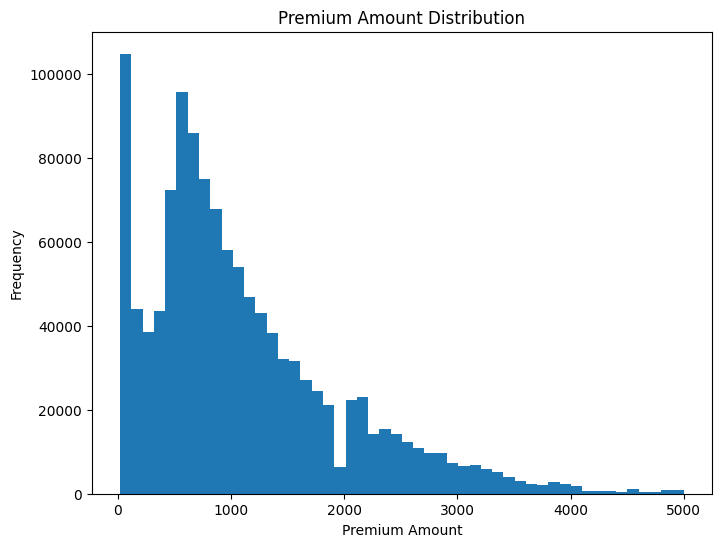

In [6]:

# Plot the distribution of the target variable
train_data['Premium Amount'].plot(kind='hist', bins=50, figsize=(8, 6), title='Premium Amount Distribution')
plt.xlabel('Premium Amount')
plt.show()


                           Age  Annual Income  Number of Dependents  \
Age                   1.000000      -0.000122              0.002046   
Annual Income        -0.000122       1.000000             -0.002563   
Number of Dependents  0.002046      -0.002563              1.000000   
Health Score         -0.000858       0.019254              0.003504   
Previous Claims       0.000092       0.030513             -0.002871   
Vehicle Age          -0.002233      -0.000286              0.000004   
Credit Score          0.001430      -0.062468              0.002636   
Insurance Duration    0.000343       0.000408             -0.000027   
Premium Amount       -0.001903      -0.004268             -0.005515   

                      Health Score  Previous Claims  Vehicle Age  \
Age                      -0.000858         0.000092    -0.002233   
Annual Income             0.019254         0.030513    -0.000286   
Number of Dependents      0.003504        -0.002871     0.000004   
Health Score     

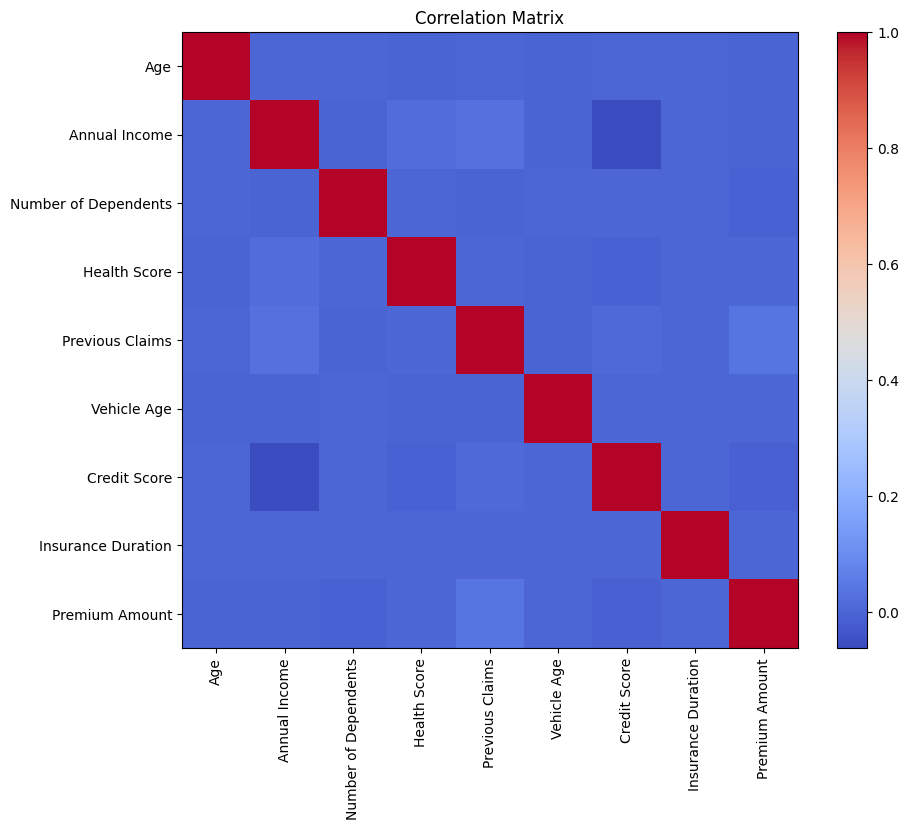

In [7]:
corr = train_data.corr(numeric_only=True)
print(corr)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

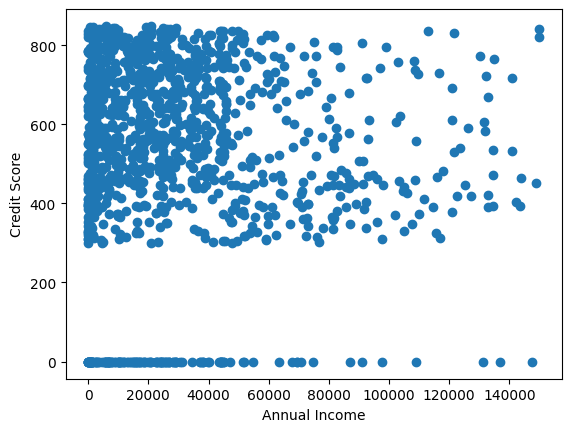

In [8]:
plt.scatter(train_data["Annual Income"][::1000], train_data["Credit Score"][::1000])
plt.xlabel("Annual Income")
plt.ylabel("Credit Score")
plt.show()

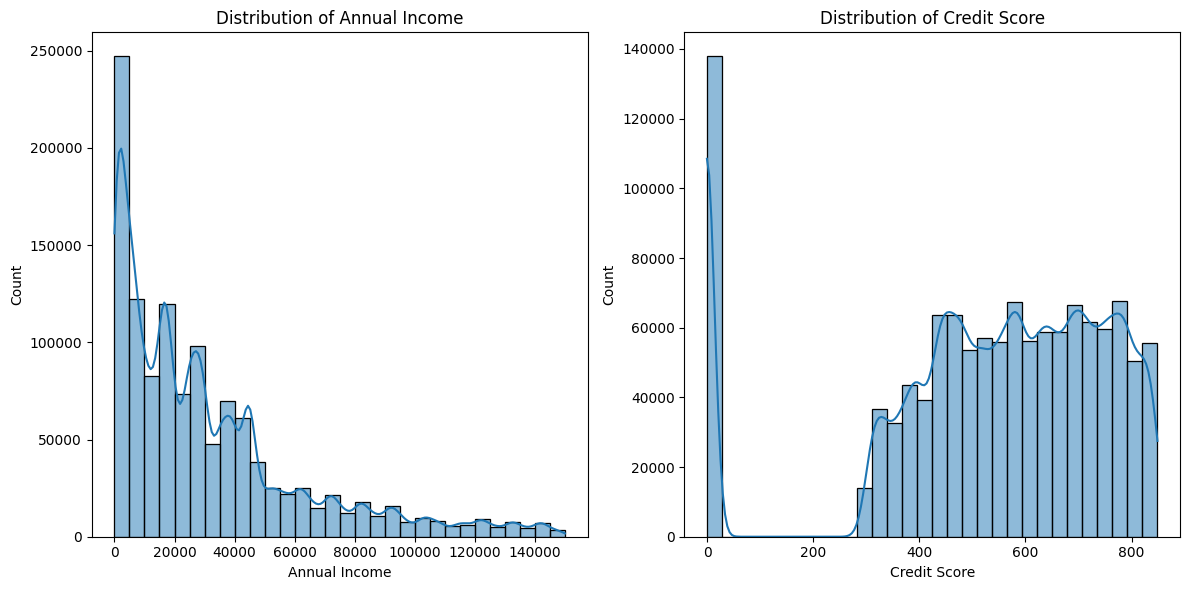

In [9]:
import seaborn as sns

# Plot distributions for Annual Income and Credit Score
plt.figure(figsize=(12, 6))

# Annual Income Distribution
plt.subplot(1, 2, 1)
sns.histplot(train_data['Annual Income'], kde=True, bins=30)
plt.title('Distribution of Annual Income')

# Credit Score Distribution
plt.subplot(1, 2, 2)
sns.histplot(train_data['Credit Score'], kde=True, bins=30)
plt.title('Distribution of Credit Score')

plt.tight_layout()
plt.show()


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   Age                   1200000 non-null  int8    
 1   Gender                1200000 non-null  category
 2   Annual Income         1200000 non-null  float32 
 3   Marital Status        1200000 non-null  category
 4   Number of Dependents  1200000 non-null  int8    
 5   Education Level       1200000 non-null  category
 6   Occupation            1200000 non-null  category
 7   Health Score          1200000 non-null  int8    
 8   Location              1200000 non-null  category
 9   Policy Type           1200000 non-null  category
 10  Previous Claims       1200000 non-null  int8    
 11  Vehicle Age           1200000 non-null  int8    
 12  Credit Score          1200000 non-null  int16   
 13  Insurance Duration    1200000 non-null  int8    
 14  Customer Feedback 

In [11]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ["Annual Income", "Credit Score", "Premium Amount"]  # Update as needed
scaler = StandardScaler()

train_data[cols_to_scale] = scaler.fit_transform(train_data[cols_to_scale])


In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
cat_cols = train_data.select_dtypes(include=["category"]).columns
for col in cat_cols:
    train_data[col] = label_encoder.fit_transform(train_data[col])


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1200000 non-null  int8   
 1   Gender                1200000 non-null  int64  
 2   Annual Income         1200000 non-null  float32
 3   Marital Status        1200000 non-null  int64  
 4   Number of Dependents  1200000 non-null  int8   
 5   Education Level       1200000 non-null  int64  
 6   Occupation            1200000 non-null  int64  
 7   Health Score          1200000 non-null  int8   
 8   Location              1200000 non-null  int64  
 9   Policy Type           1200000 non-null  int64  
 10  Previous Claims       1200000 non-null  int8   
 11  Vehicle Age           1200000 non-null  int8   
 12  Credit Score          1200000 non-null  float32
 13  Insurance Duration    1200000 non-null  int8   
 14  Customer Feedback     1200000 non-

                           Age    Gender  Annual Income  Marital Status  \
Age                   1.000000  0.000257      -0.000122        0.000349   
Gender                0.000257  1.000000      -0.001101        0.001038   
Annual Income        -0.000122 -0.001101       1.000000        0.007207   
Marital Status        0.000349  0.001038       0.007207        1.000000   
Number of Dependents  0.002046  0.000573      -0.002563       -0.000710   
Education Level      -0.000306  0.000558       0.000211       -0.000928   
Occupation           -0.001684  0.001038      -0.002680        0.000676   
Health Score         -0.000858  0.002888       0.019254        0.003074   
Location              0.001524  0.001225       0.000272        0.000672   
Policy Type          -0.000667 -0.001539      -0.001071        0.000274   
Previous Claims       0.000092 -0.000103       0.030513        0.001083   
Vehicle Age          -0.002233  0.000946      -0.000286        0.001242   
Credit Score          0.0

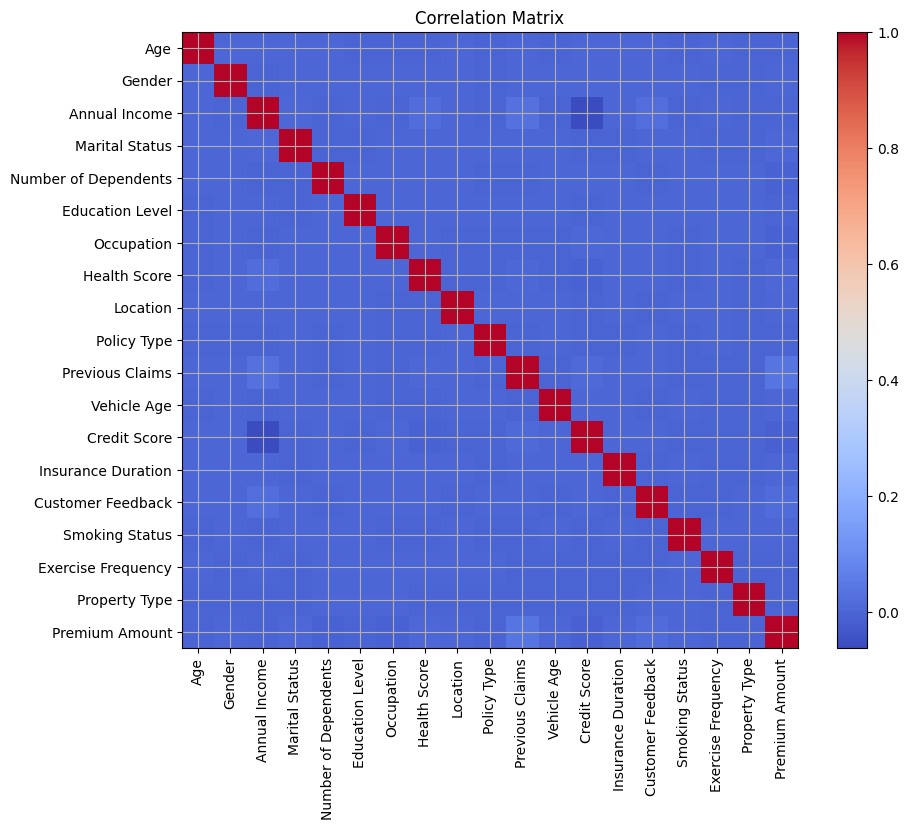

In [14]:
corr = train_data.corr(numeric_only=True)
print(corr)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.grid()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

# FAILED

couldn't find good correlations before deadline of competition